In [55]:
# Importing Libraries
import pandas as pd
import random
import numpy as np
import random
import psycopg2
from datetime import datetime, timedelta

# Set User

In [7]:
# Database connection parameters
db_params = {
    'dbname': 'SmartStrideDB',
    'user': 'hirakdesai',
    'host': 'localhost',
    'password': 'rexes',
}


In [63]:
# get user data from sql db
def get_user_data(user_id):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    cur.execute("SELECT * FROM userDB WHERE username = %s", (user_id,))
    user_data = cur.fetchone()
    cur.close()
    conn.close()
    return user_data


# calculate age from birthday
def calculate_age(birthdate):
    birthdate = birthdate.replace(' ', '')
    birthdate = pd.to_datetime(birthdate)
    today = pd.Timestamp('now')
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age


def get_user_goal(input_string: str):
    data_dict = {pair.split(':')[0].strip(): pair.split(':')[1].strip() for pair in input_string.split(',')}
    # get user data from userDB for data_dict['userName']
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    if not cursor:
        raise HTTPException(status_code=500, detail="Could not connect to the database")
    # check if user has a goal
    cursor.execute("SELECT * FROM goals WHERE username = %s", (data_dict['userName'],))
    userdb_data = cursor.fetchall()
    if len(userdb_data) == 0:
        userdb_data = {"isAvailable": 404}

    # convert userdb_data to a dictionary
    userdb_data = {cursor.description[i][0]: userdb_data[0][i] for i in range(len(cursor.description))}

    # convert userdb_data['targetdate'] to datetime object
    userdb_data['targetdate'] = datetime.strptime(userdb_data['targetdate'], '%Y-%m-%d')
    # userdb_data['targetdate'] = int days to targetdate
    userdb_data['targetdate'] = (userdb_data['targetdate'] - datetime.now()).days

    userdb_data['isAvailable'] = 200
    userdb_data['numerical_goal'] = userdb_data['goal']
    if userdb_data['program'] == 'Weight Loss':
        userdb_data['goal'] = f"Loose {userdb_data['goal']} kg"
    else:
        userdb_data['goal'] = f"Run {userdb_data['goal']} km"

    
    cursor.close()
    conn.close()
    return userdb_data


In [66]:
user_sql_data = get_user_data('yashvi')
user_goal_data = get_user_goal('userName:yashvi')


user_info = {
    'gender': user_sql_data[4],
    'age': calculate_age(user_sql_data[5]),
    'height': float(user_sql_data[6]),
    'current_weight': float(user_sql_data[7]),
    'program': user_goal_data['program'],
    'target_weight': float(user_goal_data['numerical_goal']),
    'days_to_achieve': int(user_goal_data['targetdate'])
}


# Initialize start date
start_date = '2024-03-01'


('Yashvi Agrawal', 'yashvi', 'yashvi@gmail.com', '1235', 'F', '21 / 3 / 2024', Decimal('170.00'), Decimal('48.00'), 'A', 'too cute')
{'username': 'yashvi', 'program': 'Weight Loss', 'goal': 'Loose 45 kg', 'targetdate': 25, 'startdate': '2024-03-03', 'isAvailable': 200, 'numerical_goal': '45'}
{'gender': 'F', 'age': 0, 'height': 170.0, 'current_weight': 48.0, 'program': 'Weight Loss', 'target_weight': 45.0, 'days_to_achieve': 25}


/var/folders/fv/h8flhzz90ljgbvrrq5wxfv4w0000gn/T/ipykernel_3683/2626624519.py:15: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  birthdate = pd.to_datetime(birthdate)


# Generate Run Data

In [4]:
# Function to generate synthetic data for a single run
def generate_run_data(duration_minutes, start_datetime):
    # Generate timestamps at 5-second intervals
    timestamps = pd.date_range(start=start_datetime, periods=duration_minutes * 12, freq='5s')

    # Generate initial random speed data with a more realistic range and variation
    speed_data = np.linspace(np.random.uniform(6, 8), np.random.uniform(12, 15), num=len(timestamps))
    speed_data += np.random.normal(scale=0.5, size=len(speed_data))

    # Apply a rolling mean to smoothen the speed pattern
    smooth_speed_data = pd.Series(speed_data).rolling(window=10, min_periods=1, center=True).mean().round(1)

    # Generate random inclination values (0 to 8)
    inclination_data = np.random.randint(0, 9, size=len(timestamps))

    return pd.DataFrame({'timestamp': timestamps, 'speed': smooth_speed_data, 'inclination': inclination_data})

# Generate 100 runs of synthetic data for the specific user
runs_data = []

for run_number in range(100):
    # Define run duration
    run_duration = random.randint(10, 20)

    # Generate random start time for each run
    start_datetime = pd.to_datetime(start_date) + pd.to_timedelta(random.randint(0, 1440), unit='m')

    # Generate data for the current run
    run_data = generate_run_data(run_duration, start_datetime)
    
    # Increment the start date for the next run
    start_date = (pd.to_datetime(start_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')

    # Add user information to each row
    run_data['gender'] = user_info['gender']
    run_data['age'] = user_info['age']
    run_data['height'] = user_info['height']
    run_data['current_weight'] = user_info['current_weight']
    run_data['target_weight'] = user_info['target_weight']
    run_data['weeks_to_achieve'] = user_info['weeks_to_achieve']

    runs_data.append(run_data)

# Concatenate the runs into a single DataFrame
full_data = pd.concat(runs_data, ignore_index=True)

# Save the synthetic data to a CSV file
full_data.to_csv('run_data_single_user_inclination.csv', index=False)


# Plot the run

            timestamp  speed  inclination  gender  age  height  \
0 2024-03-01 21:49:00    7.3            8  Female   22     162   
1 2024-03-01 21:49:05    7.3            0  Female   22     162   
2 2024-03-01 21:49:10    7.3            2  Female   22     162   
3 2024-03-01 21:49:15    7.3            7  Female   22     162   
4 2024-03-01 21:49:20    7.4            6  Female   22     162   

   current_weight  target_weight  weeks_to_achieve  
0              62             55                10  
1              62             55                10  
2              62             55                10  
3              62             55                10  
4              62             55                10  


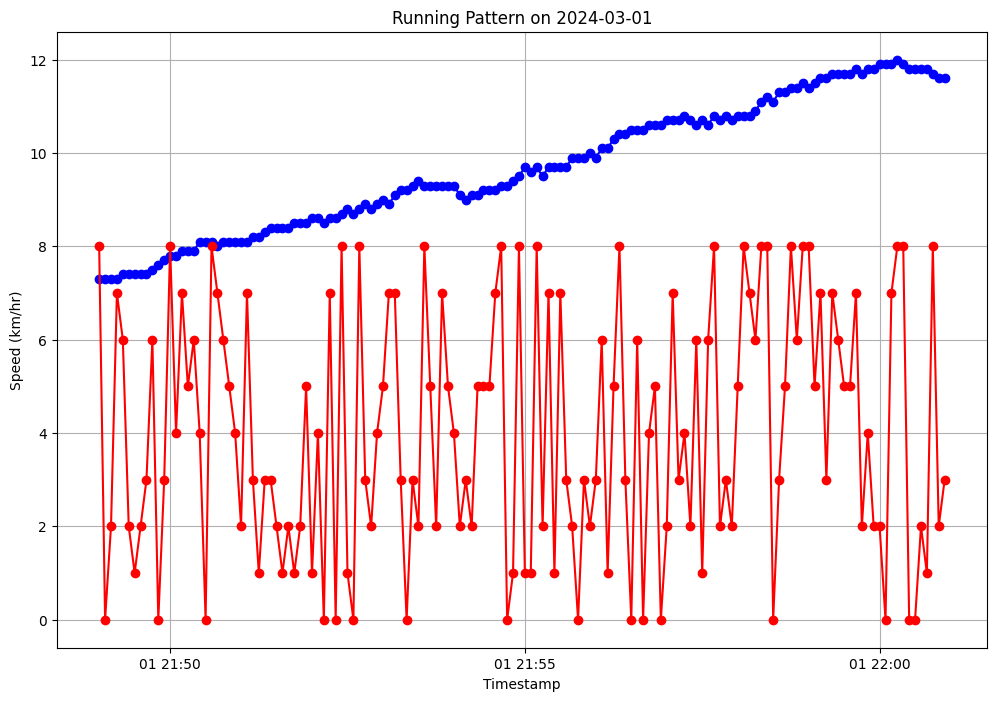

In [5]:
# Plotting the Run for a start_date
# Load the synthetic data with date
data = pd.read_csv('run_data_single_user_inclination.csv', parse_dates=['timestamp'])
print(data.head())

# Choose a specific date for plotting (change this to the desired date)
selected_date = '2024-03-01'

# Filter data for the selected date
selected_data = data[data['timestamp'].dt.date == pd.to_datetime(selected_date).date()]

# Plot speed for the selected day
plt.figure(figsize=(12, 8))
plt.plot(selected_data['timestamp'], selected_data['speed'], marker='o', linestyle='-', color='b')
plt.plot(selected_data['timestamp'], selected_data['inclination'], marker='o', linestyle='-', color='r')

plt.title(f'Running Pattern on {selected_date}')
plt.xlabel('Timestamp')
plt.ylabel('Speed (km/hr)')
plt.grid(True)
plt.show()


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the synthetic data with date
data = pd.read_csv('synth_run_data_single_user.csv', parse_dates=['timestamp'])

# Feature Engineering
data['hour_of_day'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['month'] = data['timestamp'].dt.month
data['time_of_day'] = pd.cut(data['hour_of_day'], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3])

# Running Metrics
data['average_speed'] = data.groupby('timestamp')['speed'].transform('mean')
data['max_speed'] = data.groupby('timestamp')['speed'].transform('max')
data['min_speed'] = data.groupby('timestamp')['speed'].transform('min')
data['speed_trend'] = data['speed'].rolling(window=10, min_periods=1).mean()

# Additional Derived Features
data['progress_towards_target'] = data['current_weight'] - data['target_weight']
data['speed_change'] = data['speed'].diff()

# Select relevant features for model training
features = ['age', 'height', 'current_weight', 'weeks_to_achieve', 'day_of_week', 'month', 'time_of_day', 'average_speed', 'max_speed', 'min_speed', 'speed_trend', 'progress_towards_target', 'speed_change']

# Drop unnecessary columns
data = data[features + ['speed']]  # Ensure target variable is included

# Print column names before one-hot encoding
print("Before one-hot encoding:", data.columns.tolist())

# Convert categorical features to numerical using one-hot encoding
# data = pd.get_dummies(data, columns='time_of_day', drop_first=True)

# Print column names after one-hot encoding
# print("After one-hot encoding:", data.columns.tolist())

# Split data into features and target variable
X = data[features]
y = data['speed']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Before one-hot encoding: ['age', 'height', 'current_weight', 'weeks_to_achieve', 'day_of_week', 'month', 'time_of_day', 'average_speed', 'max_speed', 'min_speed', 'speed_trend', 'progress_towards_target', 'speed_change', 'speed']
(2755, 13) (689, 13) (2755,) (689,)


/var/folders/fv/h8flhzz90ljgbvrrq5wxfv4w0000gn/T/ipykernel_48997/2331822023.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('synth_run_data_single_user.csv', parse_dates=['timestamp'])


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load your dataset (replace 'your_dataset.csv' with your actual dataset)
df = pd.read_csv('synth_run_data_single_user.csv')

# Assuming the dataset has columns 'timestamp' and 'speed'
# For simplicity, you might need to include other features based on your dataset

# Convert 'timestamp' to datetime and set it as the index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Normalize the 'speed' column
scaler = MinMaxScaler()
df['speed_normalized'] = scaler.fit_transform(df[['speed']])

# Function to create sequences for LSTM
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length]['speed_normalized']
        target = data.iloc[i+sequence_length]['speed_normalized']
        sequences.append(seq.values)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (adjust based on your requirement)
sequence_length = 10

# Create sequences and targets
sequences, targets = create_sequences(df[['speed_normalized']], sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Reshape the data to fit the LSTM model input shape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Now, you can use the trained model to generate a new run based on the past data.
# You need to create a sequence similar to the training sequences and predict the next value.

# For simplicity, let's use the last sequence from the testing data to generate a new run
new_sequence = X_test[-1].reshape(1, sequence_length, 1)
predicted_speed_normalized = model.predict(new_sequence)

# Inverse transform to get the predicted speed in the original scale
predicted_speed = scaler.inverse_transform(predicted_speed_normalized.reshape(-1, 1))

# Print the predicted speed for the next time step
print("Predicted Speed for the Next Time Step:", predicted_speed[0, 0])


2024-04-05 11:33:47.986620: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/fv/h8flhzz90ljgbvrrq5wxfv4w0000gn/T/ipykernel_48997/3498774829.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/Users/hirakdesai/Documents/Workspace/GitHub/SmartStride/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.1207 - val_loss: 0.0127
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0128 - val_loss: 0.0109
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0116 - val_loss: 0.0095
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - val_loss: 0.0066
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - val_loss: 0.0051
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - val_loss: 0.0049
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0049 - val_loss: 0.0044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
Predicted Speed for the Next Time Step: 4.266103


# Generating a new run

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

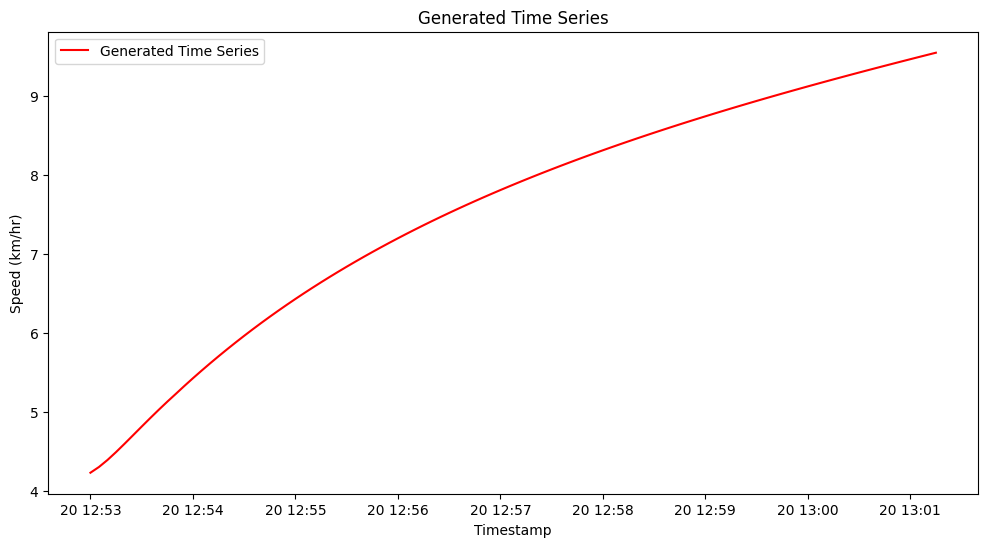

In [8]:
# Initialize the initial sequence with the last sequence from the testing data
generated_sequence = X_test[-1].reshape(1, sequence_length, 1)

# Number of time steps to generate
num_time_steps = 100

# Initialize a list to store the generated speed values
generated_speed_values = []

# Generate the time series data
for _ in range(num_time_steps):
    # Predict the next speed value
    predicted_speed_normalized = model.predict(generated_sequence)
    
    # Inverse transform to get the predicted speed in the original scale
    predicted_speed = scaler.inverse_transform(predicted_speed_normalized.reshape(-1, 1))
    
    # Append the predicted speed to the generated sequence
    generated_sequence = np.append(generated_sequence[:, 1:, :], predicted_speed_normalized.reshape(1, 1, 1), axis=1)
    
    # Append the predicted speed to the list
    generated_speed_values.append(predicted_speed[0, 0])

# Create a time index for the generated time series
generated_time_index = pd.date_range(start=df.index[-1] + pd.Timedelta(minutes=5), periods=num_time_steps, freq='5s')

# Create a DataFrame for the generated time series
generated_time_series = pd.DataFrame({'timestamp': generated_time_index, 'predicted_speed': generated_speed_values})


# Plot the generated time series
plt.figure(figsize=(12, 6))
plt.plot(generated_time_series['timestamp'], generated_time_series['predicted_speed'], label='Generated Time Series', color='red')
plt.title('Generated Time Series')
plt.xlabel('Timestamp')
plt.ylabel('Speed (km/hr)')
plt.legend()
plt.show()


In [9]:
print(generated_time_series)

             timestamp  predicted_speed
0  2024-01-20 12:53:00         4.225406
1  2024-01-20 12:53:05         4.298066
2  2024-01-20 12:53:10         4.387114
3  2024-01-20 12:53:15         4.486896
4  2024-01-20 12:53:20         4.592638
..                 ...              ...
95 2024-01-20 13:00:55         9.437443
96 2024-01-20 13:01:00         9.465167
97 2024-01-20 13:01:05         9.492740
98 2024-01-20 13:01:10         9.520171
99 2024-01-20 13:01:15         9.547463

[100 rows x 2 columns]


In [14]:
import json
from urllib.parse import urlencode
config = {
    "type": 'radialGauge',
    "data": {
        "datasets": [{
        "data": [80],
        "backgroundColor": "pink",
        }]
    },
    "options": {
        "domain": [0, 100],
        "trackColor": '#f0f8ff', 
        "centerPercentage": 90,
        "centerArea": {
        "text": '80%',
        },
    }
}
params = {
    'chart': json.dumps(config),
    'width': 500,
    'height': 300,
    'format': 'png',
}

print(f"https://quickchart.io/chart?{urlencode(params)}")

https://quickchart.io/chart?chart=%7B%22type%22%3A+%22radialGauge%22%2C+%22data%22%3A+%7B%22datasets%22%3A+%5B%7B%22data%22%3A+%5B80%5D%2C+%22backgroundColor%22%3A+%22pink%22%7D%5D%7D%2C+%22options%22%3A+%7B%22domain%22%3A+%5B0%2C+100%5D%2C+%22trackColor%22%3A+%22%23f0f8ff%22%2C+%22centerPercentage%22%3A+90%2C+%22centerArea%22%3A+%7B%22text%22%3A+%2280%25%22%7D%7D%7D&width=500&height=300&format=png


In [12]:
import json
from urllib.parse import urlencode  # python 3
config = {
    "type": "bar",
    "data": {
        "labels": ["Hello world", "Test"],
        "datasets": [{
            "label": "Foo",
            "data": [1, 2]
        }]
    }
}

params = {
    'chart': json.dumps(config),
    'width': 500,
    'height': 300,
    'format': 'png',
    'backgroundColor': 'white',
}
print('https://quickchart.io/chart?%s' % urlencode(params))

https://quickchart.io/chart?chart=%7B%22type%22%3A+%22bar%22%2C+%22data%22%3A+%7B%22labels%22%3A+%5B%22Hello+world%22%2C+%22Test%22%5D%2C+%22datasets%22%3A+%5B%7B%22label%22%3A+%22Foo%22%2C+%22data%22%3A+%5B1%2C+2%5D%7D%5D%7D%7D&width=500&height=300&format=png&backgroundColor=white


In [ ]:
# getting user data
        user_sql_data = await get_user_data(f"userName:{userName}")
        user_goal_data = await get_user_goal(f"userName:{userName}")
        
        

        user_info = {
        'gender': user_sql_data['gender'],
        'age': await calculate_age(user_sql_data['dob']),
        'height': float(user_sql_data['height']),
        'current_weight': float(user_sql_data['weight']),
        'program': user_goal_data['program'],
        'target_weight': float(user_goal_data['numerical_goal']),
        'days_to_achieve': int(user_goal_data['targetdate'])
    }

        # loading run data to a dataframe from sql
        data = await get_run_data(userName=userName)
        df = data.copy()

        # convert time to datetime
        data['time'] = pd.to_datetime(data['time'], format='%Y/%m/%d %H:%M:%S')
        

        # Feature Engineering
        data['hour_of_day'] = data['time'].dt.hour
        data['day_of_week'] = data['time'].dt.dayofweek
        data['month'] = data['time'].dt.month
        data['time_of_day'] = pd.cut(data['hour_of_day'], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3])

        # Running Metrics
        data['average_speed'] = data.groupby('runcount')['speed'].transform('mean')
        data['max_speed'] = data.groupby('runcount')['speed'].transform('max')
        data['min_speed'] = data.groupby('runcount')['speed'].transform('min')
        data['speed_trend'] = data['speed'].rolling(window=10, min_periods=1).mean()

        # Additional Derived Features
        data['progress_towards_target'] = user_info['current_weight'] - user_info['target_weight']
        data['speed_change'] = data['speed'].diff()

        # getting from user_info
        data['age'] = user_info['age']
        data['height'] = user_info['height']
        data['current_weight'] = user_info['current_weight']
        data['program'] = user_info['program']

        # lambda iterate over the rows and calculate the days to achieve by subtracting from user_goal_data['targetdate_date']
        data['days_to_achieve'] = data.apply(lambda row: (datetime.strptime(user_goal_data['targetdate_date'], '%Y-%m-%d') - row['time']).days, axis=1)
        
        # # set data['gender'] to 2 if F, 1 if M, 0 if O
        # if user_info['gender'] == 'F': data['gender'] = 2
        # elif user_info['gender'] == 'M': data['gender'] = 1
        # else: data['gender'] = 0


        # Convert object columns to float64
        data['average_speed'] = pd.to_numeric(data['average_speed'], errors='coerce')
        data['max_speed'] = pd.to_numeric(data['max_speed'], errors='coerce')
        data['min_speed'] = pd.to_numeric(data['min_speed'], errors='coerce')
        data['speed_change'] = pd.to_numeric(data['speed_change'], errors='coerce')
        data['speed'] = pd.to_numeric(data['speed'], errors='coerce')


        # Select relevant features for model training
        features = ['age', 'height', 'current_weight', 'days_to_achieve', 'day_of_week', 'month', 'time_of_day', 'average_speed', 'max_speed', 'min_speed', 'speed_trend', 'progress_towards_target', 'speed_change', 'inclination']

        # Drop unnecessary columns
        data = data[features + ['speed']]  # Ensure both target variables are included


        # Split data into features and target variables
        X = data[features]
        y_speed = data['speed']
        y_inclination = data['inclination']

        # Split data into training and testing sets for speed prediction
        X_train_speed, X_test_speed, y_train_speed, y_test_speed = train_test_split(X, y_speed, test_size=0.2, random_state=42)

        # Split data into training and testing sets for inclination prediction
        X_train_inclination, X_test_inclination, y_train_inclination, y_test_inclination = train_test_split(X, y_inclination, test_size=0.2, random_state=42)

    

        # Normalize the 'speed' column
        scaler = MinMaxScaler()
        data['speed_normalized'] = scaler.fit_transform(data[['speed']])

        # Function to create sequences for LSTM
        def create_sequences(data, sequence_length):
            sequences = []
            targets = []
            for i in range(len(data) - sequence_length):
                seq = data.iloc[i:i+sequence_length]['speed_normalized']
                target = data.iloc[i+sequence_length]['speed_normalized']
                sequences.append(seq.values)
                targets.append(target)
            return np.array(sequences), np.array(targets)

        # Define the sequence length
        sequence_length = 10

        # Create sequences and targets
        sequences, targets = create_sequences(data[['speed_normalized']], sequence_length)

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

        # Reshape the data to fit the LSTM model input shape
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Define whether to use pre-trained model
        use_model = True

        # Load or train the model for speed prediction
        if use_model:
            model_speed = load_model('model_speed.h5')
        else:
            model_speed = Sequential()
            model_speed.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
            model_speed.add(Dense(1))
            model_speed.compile(optimizer='adam', loss='mean_squared_error')

            # Train the model for speed prediction
            model_speed.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

            # Save the model for speed prediction
            model_speed.save('model_speed.h5')

        # Generate a run for speed prediction
        num_time_steps = 20
        generated_sequence_speed = np.zeros((1, X_train.shape[1], 1))
        generated_speed_values = []

        for _ in range(num_time_steps):
            predicted_speed = model_speed.predict(generated_sequence_speed)
            generated_sequence_speed = np.append(generated_sequence_speed[:, 1:, :], predicted_speed.reshape(1, 1, 1), axis=1)
            generated_speed_values.append(predicted_speed[0, 0])

        # Create a DataFrame for the generated time series for speed
        generated_time_index_speed = pd.date_range(end=pd.Timestamp.now(), periods=num_time_steps, freq='5s')
        generated_time_series_speed = pd.DataFrame({'timestamp': generated_time_index_speed, 'predicted_speed': generated_speed_values})



        # inclinations are speed dependent
        # inclination = round(speed * 0.1, 0)
        # Generate a run for inclination prediction
        generated_inclination_values = [round(speed * 0.1, 0) for speed in generated_speed_values]

        # Create a DataFrame for the generated time series for inclination
        generated_time_series_speed['predicted_inclination'] = generated_inclination_values


        # Combine the generated time series for speed and inclination
        combined_generated_time_series = generated_time_series_speed[['timestamp', 'predicted_speed', 'predicted_inclination']]
        return {"generated_time_series": combined_generated_time_series}